## Mask RCNN ResNet 101 (Blank Mask)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import json
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
from torchvision import transforms as T
from torchvision.datasets.coco import CocoDetection
from torchvision.models.detection import maskrcnn_resnet50_fpn, FastRCNNPredictor

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

## Dataset form

In [ ]:
class COCOVehicleDataset(Dataset):
    def __init__(self, img_dir, ann_path, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        with open(ann_path) as f:
            self.coco = json.load(f)
        
        self.imgs = {img['id']: img for img in self.coco['images']}
        self.anns = {}
        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            if img_id not in self.anns:
                self.anns[img_id] = []
            self.anns[img_id].append(ann)
        self.image_ids = list(self.imgs.keys())

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.imgs[img_id]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        boxes, labels, masks = [], [], []

        for ann in self.anns.get(img_id, []):
            bbox = ann['bbox']
            x, y, w, h = bbox
            boxes.append([x, y, x+w, y+h])
            labels.append(1)  
            rle_mask = cv2.imread(img_path, 0)  # dummy mask 
            masks.append(torch.zeros((img.height, img.width), dtype=torch.uint8))  

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.stack(masks)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)


## Model

In [76]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = maskrcnn_resnet50_fpn(backbone_name='resnet101', pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, 2)  # 1 class + background
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 233MB/s] 


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## Data Load

In [77]:
import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)


In [78]:
train_dataset = COCOVehicleDataset(
    img_dir="/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images",
    ann_path="/kaggle/input/coco-format/train_coco.json",
    transforms=get_transform(train=True)
)

val_dataset = COCOVehicleDataset(
    img_dir="/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images",
    ann_path="/kaggle/input/coco-format/val_coco.json",
    transforms=get_transform(train=False)
)


In [79]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


## Training

In [80]:
import torch.optim as optim

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 50


In [81]:
from tqdm.notebook import tqdm
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    batch_losses = []
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    for images, targets in tqdm(train_loader, desc="Training", leave=False):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        batch_losses.append(losses.item())
        total_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.4f}")



Epoch [1/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [1/50] - Avg Loss: 0.4352

Epoch [2/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [2/50] - Avg Loss: 0.3171

Epoch [3/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [3/50] - Avg Loss: 0.2771

Epoch [4/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [4/50] - Avg Loss: 0.2497

Epoch [5/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [5/50] - Avg Loss: 0.2217

Epoch [6/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [6/50] - Avg Loss: 0.2089

Epoch [7/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [7/50] - Avg Loss: 0.1895

Epoch [8/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [8/50] - Avg Loss: 0.1724

Epoch [9/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [9/50] - Avg Loss: 0.1589

Epoch [10/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [10/50] - Avg Loss: 0.1470

Epoch [11/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [11/50] - Avg Loss: 0.1479

Epoch [12/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [12/50] - Avg Loss: 0.1360

Epoch [13/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [13/50] - Avg Loss: 0.1285

Epoch [14/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [14/50] - Avg Loss: 0.1150

Epoch [15/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [15/50] - Avg Loss: 0.1096

Epoch [16/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [16/50] - Avg Loss: 0.1029

Epoch [17/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [17/50] - Avg Loss: 0.0950

Epoch [18/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [18/50] - Avg Loss: 0.0946

Epoch [19/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [19/50] - Avg Loss: 0.0903

Epoch [20/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [20/50] - Avg Loss: 0.0868

Epoch [21/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [21/50] - Avg Loss: 0.0898

Epoch [22/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [22/50] - Avg Loss: 0.0847

Epoch [23/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [23/50] - Avg Loss: 0.0779

Epoch [24/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [24/50] - Avg Loss: 0.0809

Epoch [25/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [25/50] - Avg Loss: 0.0866

Epoch [26/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [26/50] - Avg Loss: 0.0784

Epoch [27/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [27/50] - Avg Loss: 0.0748

Epoch [28/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [28/50] - Avg Loss: 0.0707

Epoch [29/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [29/50] - Avg Loss: 0.0690

Epoch [30/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [30/50] - Avg Loss: 0.0707

Epoch [31/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [31/50] - Avg Loss: 0.0713

Epoch [32/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [32/50] - Avg Loss: 0.0716

Epoch [33/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [33/50] - Avg Loss: 0.0691

Epoch [34/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [34/50] - Avg Loss: 0.0683

Epoch [35/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [35/50] - Avg Loss: 0.0709

Epoch [36/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [36/50] - Avg Loss: 0.0800

Epoch [37/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [37/50] - Avg Loss: 0.0744

Epoch [38/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [38/50] - Avg Loss: 0.0706

Epoch [39/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [39/50] - Avg Loss: 0.0646

Epoch [40/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [40/50] - Avg Loss: 0.0629

Epoch [41/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [41/50] - Avg Loss: 0.0633

Epoch [42/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [42/50] - Avg Loss: 0.0634

Epoch [43/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [43/50] - Avg Loss: 0.0670

Epoch [44/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [44/50] - Avg Loss: 0.0628

Epoch [45/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [45/50] - Avg Loss: 0.0604

Epoch [46/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [46/50] - Avg Loss: 0.0619

Epoch [47/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [47/50] - Avg Loss: 0.0635

Epoch [48/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [48/50] - Avg Loss: 0.0611

Epoch [49/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [49/50] - Avg Loss: 0.0591

Epoch [50/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [50/50] - Avg Loss: 0.0599


In [ ]:
torch.save(model.state_dict(), "mrcnnres101_vehicle_detector.pth") # save model


## Evaluation

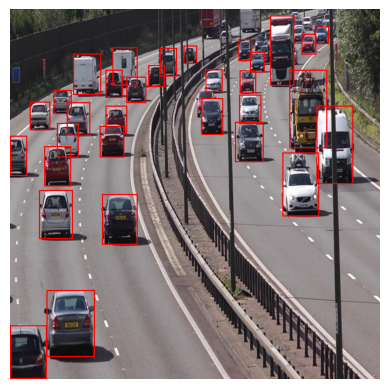

In [83]:
from PIL import ImageDraw

def infer_and_show(image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    image_draw = image.copy()
    draw = ImageDraw.Draw(image_draw)

    for box, score in zip(prediction["boxes"], prediction["scores"]):
        if score > 0.5:
            x1, y1, x2, y2 = box.cpu().numpy().astype(int)
            draw.rectangle(((x1, y1), (x2, y2)), outline="red", width=2)

    plt.imshow(image_draw)
    plt.axis("off")
    plt.show()

infer_and_show("/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images/10_mp4-25_jpg.rf.11c919cc683cc6a0d0a658be13483748.jpg")


In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2) 

model.load_state_dict(torch.load("mrcnnres101_vehicle_detector.pth"))
model.to(device)
model.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
def count_vehicles(image_path):
    from PIL import Image, ImageDraw
    import torchvision.transforms.functional as F

    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    vehicle_count = sum(score.item() > 0.5 for score in prediction['scores'])
    print(f"🚌 Detected {vehicle_count} vehicles in image: {os.path.basename(image_path)}")

   
    draw = ImageDraw.Draw(image)
    for box, score in zip(prediction['boxes'], prediction['scores']):
        if score > 0.5:
            x1, y1, x2, y2 = box.int().tolist()
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    display(image)


🚌 Detected 3 vehicles in image: 6_mp4-14_jpg.rf.a5099c3eeb2c707a2193c0efa467bb2a.jpg


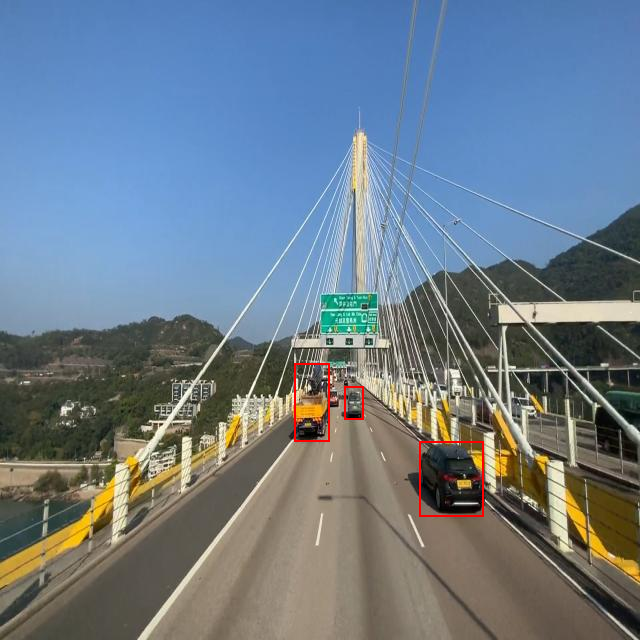

🚌 Detected 27 vehicles in image: 10_mp4-39_jpg.rf.af70092b5f2277f16d2703a4d59c3313.jpg


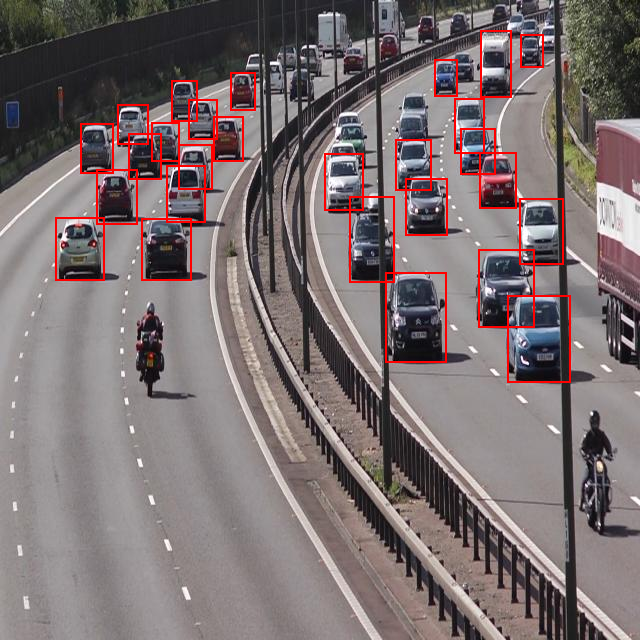

🚌 Detected 18 vehicles in image: 8_mp4-39_jpg.rf.bf01d183fca62e3316a0e4b31bfdf0da.jpg


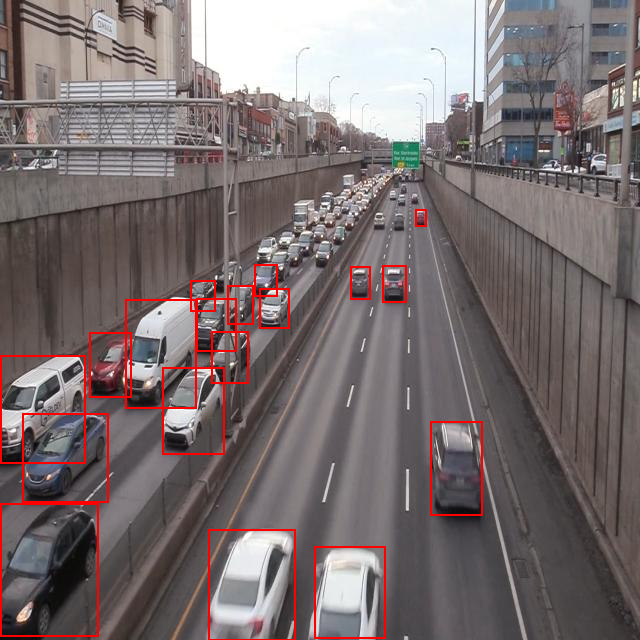

🚌 Detected 1 vehicles in image: 3_mp4-14_jpg.rf.6597c5732e0d554f1f07edb59abb4f8b.jpg


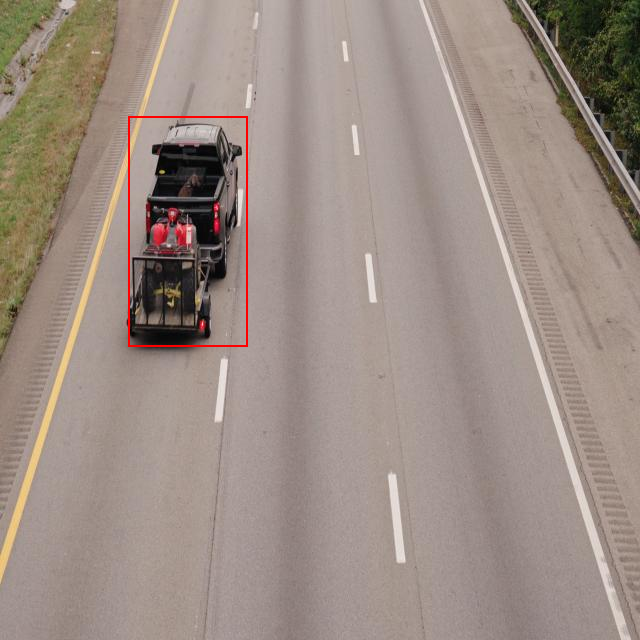

🚌 Detected 19 vehicles in image: test2_mp4-8_jpg.rf.c10dd559d44a868fd6f6877fd734815a.jpg


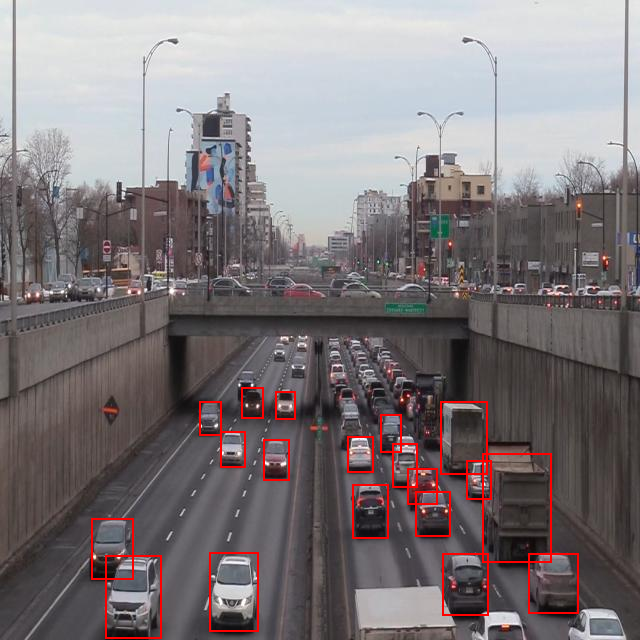

In [ ]:
val_image_dir = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
for fname in os.listdir(val_image_dir)[20:25]: 
    count_vehicles(os.path.join(val_image_dir, fname))


## Metrics

In [ ]:
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH  = "/kaggle/working/mrcnnres101_vehicle_detector.pth"
IMG_DIR     = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
ANN_PATH    = "/kaggle/input/coco-format/val_coco.json"
CONF_THRESH = 0.5

model = maskrcnn_resnet50_fpn(backbone_name='resnet101', weights='DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)


model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

coco_gt   = COCO(ANN_PATH)
img_ids   = coco_gt.getImgIds()
cat_ids   = coco_gt.getCatIds()
CAT_ID    = cat_ids[0]  

to_tensor = T.ToTensor()
preds = []

for img_id in img_ids:
    info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(IMG_DIR, info["file_name"])
    img = Image.open(img_path).convert("RGB")
    tensor = to_tensor(img).to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        out = model(tensor)[0]

    boxes  = out["boxes"].cpu().numpy()
    scores = out["scores"].cpu().numpy()

    for box, score in zip(boxes, scores):
        if score < CONF_THRESH:
            continue
        x1, y1, x2, y2 = box
        preds.append({
            "image_id":    img_id,
            "category_id": CAT_ID,
            "bbox":        [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
            "score":       float(score)
        })

with open("predictions.json", "w") as f:
    json.dump(preds, f)

coco_dt   = coco_gt.loadRes("predictions.json")
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.661
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.921
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.835
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.707
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

## Video Testing

In [90]:
import cv2
import torch
from torchvision import transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Config
VIDEO_PATH = "/kaggle/input/vidtryyy/56310-479197605_small.mp4"
MODEL_PATH = "/kaggle/working/mrcnnres101_vehicle_detector.pth"
SAVE_PATH  = "output_detected_video.mp4"
CONF_THRESH = 0.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = maskrcnn_resnet50_fpn(backbone_name='resnet101', weights='DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

# Preprocessing
transform = T.ToTensor()

# Open video
cap = cv2.VideoCapture(VIDEO_PATH)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)

# Save video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_vid = cv2.VideoWriter(SAVE_PATH, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img_rgb).to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        output = model(img_tensor)[0]

    boxes = output['boxes'].cpu()
    scores = output['scores'].cpu()
    labels = output['labels'].cpu()

    vehicle_count = 0

    for box, score, label in zip(boxes, scores, labels):
        if score < CONF_THRESH:
            continue
        vehicle_count += 1
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red box
        cv2.putText(frame, f"Vehicle: {score:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)  # Red text

    # Show vehicle count on top-left corner
    cv2.putText(frame, f"Vehicles: {vehicle_count}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)

    out_vid.write(frame)

cap.release()
out_vid.release()
print("✔️ Detection video saved:", SAVE_PATH)


✔️ Detection video saved: output_detected_video.mp4


## Thank You!